In [5]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [6]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [21]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.358592
sanity check: 2.302585


In [ ]:
#다음은 정답 코드입니다.
# def softmax_loss_naive(W, X, y, reg):
#     """
#     Softmax loss function, naive implementation (with loops)

#     Inputs have dimension D, there are C classes, and we operate on minibatches
#     of N examples.

#     Inputs:
#     - W: A numpy array of shape (D, C) containing weights.
#     - X: A numpy array of shape (N, D) containing a minibatch of data.
#     - y: A numpy array of shape (N,) containing training labels; y[i] = c means
#       that X[i] has label c, where 0 <= c < C.
#     - reg: (float) regularization strength

#     Returns a tuple of:
#     - loss as single float
#     - gradient with respect to weights W; an array of same shape as W
#     """
#     # Initialize the loss and gradient to zero.
#     loss = 0.0
#     dW = np.zeros_like(W)

#     #############################################################################
#     # TODO: Compute the softmax loss and its gradient using explicit loops.     #
#     # Store the loss in loss and the gradient in dW. If you are not careful     #
#     # here, it is easy to run into numeric instability. Don't forget the        #
#     # regularization!                                                           #
#     #############################################################################
#     # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#     #1. 점수계산 -> 2. 각 인스턴스의 점수를 모두 지수화 -> 3. 정답항만 normalize
#     # -> 4. 정답항만 -log취해주기.
#     num_classes = W.shape[1]
#     num_train = X.shape[0]
#     for i in range(num_train) :
#       scores = np.dot(X[i],W)
#       scores = np.exp(scores)
#       scores = scores / np.sum(scores)
#       loss += -np.log(scores[y[i]])

#       #Gradient 계산
#       for j in range(num_classes) :
#         if j == scores[y[i]] : # 정답 클래스
#           dW[:, j] += (scores[j] - 1) * X[i]
#         else:  # 비정답 클래스
#           dW[:, j] += scores[j] * X[i]
#     #평균 손실&그라디언트 계산
#     loss /= num_train
#     dW /= num_train

#     #정규화 추가
#     loss += 0.5 * reg * np.sum(W * W)
#     dW += reg * W

#     # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#     return loss, dW

**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$

아직 학습을 시작하기 이전이다.
따라서 확률은 균등분포를 가지는 것이 자연스럽다.
10개의 클래스를 가지기 때문에 확률은 10% 즉, 0.1을 가지게 되고 -log(0.1)을 취하게 되면 이는 약 2.302585로 계산된다.

In [22]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.978898 analytic: -1.978898, relative error: 3.048288e-08
numerical: -3.486895 analytic: -3.486895, relative error: 1.921875e-09
numerical: -1.163049 analytic: -1.163049, relative error: 5.982860e-08
numerical: 1.583967 analytic: 1.583967, relative error: 6.223518e-09
numerical: 1.097275 analytic: 1.097275, relative error: 7.173770e-08
numerical: -0.158901 analytic: -0.158901, relative error: 1.540322e-07
numerical: -2.744485 analytic: -2.744485, relative error: 3.178276e-08
numerical: -0.321014 analytic: -0.321014, relative error: 1.832596e-07
numerical: -1.339664 analytic: -1.339664, relative error: 1.728182e-08
numerical: -2.691526 analytic: -2.691526, relative error: 1.498062e-08
numerical: 1.096354 analytic: 1.096353, relative error: 6.538853e-08
numerical: 0.894320 analytic: 0.894320, relative error: 5.006127e-08
numerical: -0.189411 analytic: -0.189411, relative error: 9.551935e-08
numerical: -1.699070 analytic: -1.699070, relative error: 8.410877e-09
numerical: 3.4

In [31]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.358592e+00 computed in 0.092870s
vectorized loss: 2.358592e+00 computed in 0.011042s
Loss difference: 0.000000
Gradient difference: 0.000000


In [33]:
from re import S
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for i in learning_rates :
  for j in regularization_strengths :
    #softmax 분류기 호출
    softmax = Softmax()
    #모델 학습
    softmax.train(X_train, y_train, learning_rate=i, reg=j, num_iters=1500, verbose=True)
    #훈련 정확도
    y_train_pred = softmax.predict(X_train)
    train_accuracy = np.mean(y_train == y_train_pred)
    #검증 정확도
    y_val_pred = softmax.predict(X_val)
    val_accuracy = np.mean(y_val == y_val_pred)
    #결과 저장
    results[(i, j)] = (train_accuracy, val_accuracy)
    if best_val < val_accuracy :
      best_val = val_accuracy
      best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 392.105737
iteration 100 / 1500: loss 236.168979
iteration 200 / 1500: loss 143.372496
iteration 300 / 1500: loss 87.275115
iteration 400 / 1500: loss 53.590066
iteration 500 / 1500: loss 33.318018
iteration 600 / 1500: loss 20.930859
iteration 700 / 1500: loss 13.465746
iteration 800 / 1500: loss 8.995394
iteration 900 / 1500: loss 6.194985
iteration 1000 / 1500: loss 4.501500
iteration 1100 / 1500: loss 3.562993
iteration 1200 / 1500: loss 2.978945
iteration 1300 / 1500: loss 2.580695
iteration 1400 / 1500: loss 2.292276
iteration 0 / 1500: loss 778.467997
iteration 100 / 1500: loss 286.081844
iteration 200 / 1500: loss 106.060213
iteration 300 / 1500: loss 40.020592
iteration 400 / 1500: loss 15.950740
iteration 500 / 1500: loss 7.198990
iteration 600 / 1500: loss 3.968668
iteration 700 / 1500: loss 2.773074
iteration 800 / 1500: loss 2.325715
iteration 900 / 1500: loss 2.132161
iteration 1000 / 1500: loss 2.060302
iteration 1100 / 1500: loss 2.027985
iterat

In [34]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.354000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$

True


$\color{blue}{\textit Your Explanation:}$

트레이닝 세트에 새로운 데이터 포인트를 추가함에 따라 두 손실 함수의 손실값이 차이가 나는 이유는 다음과 같다.

SVM에서는 일정 Margin을 넘어서게 되면 성능의 개선에는 관심이 없다. 이는 hinge loss 함수의 특성이다.

이와 달리 softMax에서는 각 클래스의 스코어 자체에 관심을 갖는다. 따라서 Cross Entropy를 통하여 정답 클래스의 확률에 초점을 맞춘다. 즉 softMaxt에서는 -log(x)의 x를 1로 만들어서 Loss를 0으로 보내고 정답확률을 1로 만들기 위해 노력하기 때문이다.

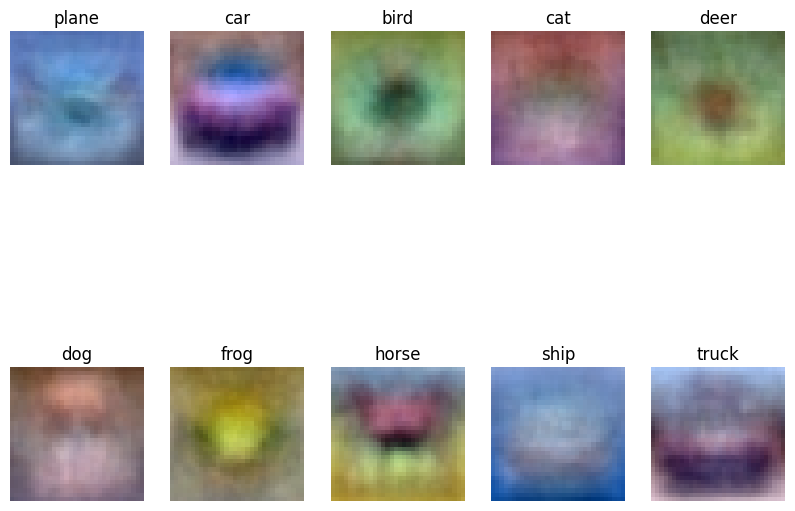

In [35]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])